# Machine Learned Sentiment Analysis using Python

“Can our project correctly classify the sentiment of just about any
sentence in the English language?”

Our goal is to build and train a model that will be able to classify more
than one dataset with over 70% accuracy on each of them. To this end,
we might have to adjust some properties to avoid overfitting to one of the
datasets to have it perform better on a general scale. Because we are
still beginners to machine learning, we are more focused on getting a
model successfully running.


**Run the code cell below** to import the required packages.

To start with, we will import the libraries by nltk (Natural Language Toolkit) package, which contains 5000
which will help us with the preprocessing and training of our model. We will
also need some libraries such as regular expressions to filter out
unnecessary data.

In [1]:
import re
import string
import pandas as pd
import numpy as np
import sklearn.model_selection   # for train and test splits
import seaborn as sns
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import itertools
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D




nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\meskandari\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

# 1.0 Binary classification using binary logistic regression

For the first part of this notebook we will build a binary classification
model, evaluated using logistic regression, as we learned in class.

### 1.1 Preprocessing the data
**Stop-Word Removal** : In English, words like a, an, the, as, in, on,
etc. are considered as stop-words so according to our requirements
we can remove them to reduce vocabulary size as these words don't
contribute to the final meaning or sentiment of a sentence.
To do this, we import the stopwords list from nltk. We also tokenize
each sentence  string into a list of words after cleaning up filler words
such as retweet, hashtags, and URLs.

As a final step, we perform stemming: **stemming** refers to the process of
removing suffixes and reducing a word to some base form such that all
different variants of that word can be represented by the same form
(e.g., “walk” and “walking” are both reduced to “walk”).

In [2]:
#Preprocessing tweets
def process_tweet(tweet):
    #Remove old style retweet text "RT"
    cleaned_tweet = re.sub(r'^RT[\s]','', tweet)

    #Remove URLS
    cleaned_tweet = re.sub(r'https?:\/\/.*[\r\n]*','', cleaned_tweet)

    #Remove hashtags
    cleaned_tweet = re.sub(r'#','',cleaned_tweet)

    #Instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)

    #Tokenize tweets
    tweet_tokens = tokenizer.tokenize(cleaned_tweet)

    #Import the english stop words list from nltk
    stopwords_english = stopwords.words('english')

    #Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)

    #Instantiate stemming class
    stemmer = PorterStemmer()

    #Creating a list of stems of words in tweet
    tweets_stem = []
    for word in tweets_clean:
        stem_word = stemmer.stem(word)
        tweets_stem.append(stem_word)

    return tweets_stem

### 1.2 Building the Frequency Dictionary

Here we define a function that will take as input tweets and their labels
as parameters. It will go through every tweet, preprocess them with the
function we just defined, count the occurrence of every word in the data
set and create a frequency dictionary.

In [3]:
#Frequency generating function
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist() #squeeze is needed or the list
                                     # will end up with one element

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    return freqs

Next, let's create a function that will extract features from a tweet
through the use of the ‘freqs’ dictionary and the defined process_tweet
function from earlier.

In [4]:
def extract_features(tweet, freqs):
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)

    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3))

    #bias term is set to 1
    x[0,0] = 1

    # loop through each word in the list of words
    for word in word_l:

        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)

        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)

    assert(x.shape == (1, 3))
    return x

def extract_features_multi_class(tweet, freqs):
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)

    # 3 elements in the form of a 1 x 4 vector
    x = np.zeros((1, 4))

    #bias term is set to 1
    x[0,0] = 1

    # loop through each word in the list of words
    for word in word_l:
            
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)

        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
        # increment the word count for the neutral label 2
        x[0,3] += freqs.get((word,2),0)

    assert(x.shape == (1, 4))
    return x

Continuing, we are importing the sample tweets from nltk and splitting
the data into training sets and test sets.

In [5]:
#import dataset from nltk
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

#create labels
one_array = [1] * len(all_positive_tweets)
zero_array = [0] * len(all_negative_tweets)

all_tweets = all_positive_tweets + all_negative_tweets
all_labels = one_array + zero_array
tweets_and_labels = np.vstack((all_tweets,all_labels)).T

#introduce randomization to the training and test sets
np.random.shuffle(tweets_and_labels)

#extract X (data) and y (labels) columns
nltk_X = tweets_and_labels[:,0].tolist()
nltk_y = tweets_and_labels[:,1].T.astype(int).tolist()

#split the data set into train and test sets with a 80/20 ratio
nltk_X_train, nltk_X_test, nltk_y_train, nltk_y_test = sklearn.model_selection.train_test_split(nltk_X, nltk_y, test_size=0.20)
nltk_y_train = np.array([nltk_y_train]).T
nltk_y_test = np.array([nltk_y_test]).T

With our required functions for processing tweets ready to go, we can begin
to build our logistic regression model.

The logistic regression maps the input $\mathbf{x}_i$ into the following
output:

$p(y_i = 1 \mid \mathbf{x}_i, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x}_i) =  \sigma(w_0 + w_1 x_1 + w_2 x_2)$.

$\sigma$ is the sigmoid function, that is defined as:

$\sigma(z) = \frac{1}{1 + e^{-z}} = (1+e^{-z})^{-1}$

The output of the sigmoid function is a value between 0 and 1. Let us
define the sigmoid function to be used in the model.

In [6]:
def sigmoid(z):
    """Returns the element-wise logistic sigmoid of z."""
    # Your code here. Aim for 1 line.
    return 1 / (1 + np.exp(-z))

## 1.3 Cost Function and Gradient Descent

Our goal is to find a configuration of our parameters $\mathbf{w}$ that
minimizes our objective function (BCE). For logistic regression, we use
the binary cross-entropy loss. Recall from Lecture 1 that the basic
logistic regression training objective (learning objective) is:

$$
\ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N y_i \ln \sigma(\mathbf{w}^T \mathbf{x}_i) + (1-y_i) \ln \left(1-\sigma(\mathbf{w}^T \mathbf{x}_i)\right)
$$

The "basic" gradient for the above training objective is on a slide
titled "Maximum likelihood estimate for LR" from Lecture 1, and
reproduced here:

$$
\nabla \ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N (\sigma(\mathbf{w}^T \mathbf{x}_i) - y_i)\mathbf{x}_i
$$

Let's define a few functions that implement these operations.

In [7]:
def gradient_descent(x, y, w, lr, num_iters):

    m = len(x)

    for i in range(0, num_iters):

        z = np.dot(x,w)
        h = sigmoid(z)

        # calculate the cost function
        J = (-1/m)*(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)))

        # update the weights by gradient descent
        w = w - (lr/m)*np.dot(x.T, h-y)

    J = float(J)
    return J, w

### 1.4 Training and Testing our Model

As all the required functions are ready we can finally train our model
using the training set.

In [8]:
nltk_freqs = build_freqs(nltk_X_train, nltk_y_train)

# collect the features 'x' and stack them into a matrix 'X'
nltk_X_gd = np.zeros((len(nltk_X_train), 3))
for i in range(len(nltk_X_train)):
    nltk_X_gd[i, :]= extract_features(nltk_X_train[i], nltk_freqs)

# training labels corresponding to X
nltk_Y_gd = nltk_y_train

# Apply gradient descent to extract the weight vector w
nltk_J, nltk_w = gradient_descent(nltk_X_gd, nltk_Y_gd, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost function at the end of training is {nltk_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(nltk_w)]}")

The cost function at the end of training is 0.24184619.
The resulting vector of weights is [7e-08, 0.00052221, -0.00055733]


Right above here, we receive and print the final cost J as well as the
weight matrix w after all the training is done. This weight matrix
constitutes our binary classification based on logistic regression model.

Let's proceed to write two more functions which when given a tweet, will
predict results using the freqs dictionary and weights matrix. The second
function will use the predict function and provide the accuracy of
the model on the given testing data set.

In [9]:
def predict_tweet(tweet, freqs, theta):
    """
    Input:
        tweet: a string
        freqs: a dictionary of the frequencies of each tuple (word, label)
        theta: vector of weights
    Output:
        y_pred: the probability of a tweet being positive or negative
    """

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)

    # make the prediction using x and theta
    z = np.dot(x,theta)
    y_pred = sigmoid(z)
    return y_pred

def test_logistic_regression(X_test, y_test, freqs, theta):
    """
    Input:
        X_test: a list of tweets
        y_test: vector with the corresponding labels for the list of tweets
        freqs: a dictionary of the frequencies of each tuple (word, label)
        theta: vector of weights
    Output:
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """

    # the list for storing predictions
    y_hat = []

    for tweet in X_test:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
    # With the above implementation, y_hat is a list, but test_y is a
    # (m,1) array
    # convert both to one-dimensional arrays in order to compare them
    # using the '==' operator
    y_hat = np.array(y_hat)
    test_y = y_test.reshape(-1)
    accuracy = np.sum((test_y == y_hat).astype(int))/len(X_test)

    return accuracy

With all the required functions defined, we can proceed to try out our
model and look at the output.

In [10]:
acc = test_logistic_regression(nltk_X_test, nltk_y_test, nltk_freqs, nltk_w)

print("The accuracy on the test set is {}%".format(acc*100))

The accuracy on the test set is 99.2%


We have obtained a pretty high accuracy (around 99.0%) with the trained
model. Let's formulate a few sentences and see what the model predicts
out of them.

In [11]:
tweet = "I hate insta so much everyone is nicer on here"
prediction = predict_tweet(tweet, nltk_freqs, nltk_w)
print("This tweet is positive" if prediction >= 0.5 else "This tweet is negative")

tweet = "Everyday is my favorite, waking up one more day makes each day awesome"
prediction = predict_tweet(tweet, nltk_freqs, nltk_w)
print("This tweet is positive" if prediction >= 0.5 else "This tweet is negative")

tweet = "Checking the box full of ole' photos is always fun!"
prediction = predict_tweet(tweet, nltk_freqs, nltk_w)
print("This tweet is positive" if prediction >= 0.5 else "This tweet is negative")

This tweet is negative
This tweet is positive
This tweet is positive


### 1.6 Expanding the data set

Let's continue exploring the model by training it using another popular data
set. The data set in question is "Twitter US Airline Sentiment" (retrieved
from https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?resource=download ).
For the ease of use we have included the data set already
within the repository. Let's do a few lines of code to import and preview
the data in the files.

In [12]:
df = pd.read_csv('Tweets.csv')
print(df.shape)
df.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Unlike our previous data set, this one contains more columns which we might
not need. It is our job to process the data to make it fit the model
defined above. However, do observe that there is one more sentiment in the
labels: the neutral label.

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


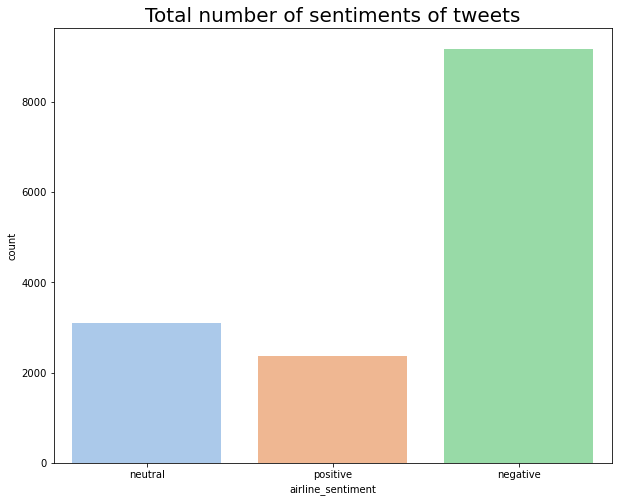

In [13]:
print(df.airline_sentiment.value_counts())
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = 'airline_sentiment', data = df, palette = 'pastel')
ax.set_title(label = 'Total number of sentiments of tweets', fontsize = 20)
plt.show()

Let's define a few functions that will help us with the text processing.
Remember, currently we are working with binary classification of positive
and negative sentiments. For this reason, we will be discarding all neutral
labels and their corresponding data.

In [14]:
#remove all neutral-labeled data
df =  df[df.airline_sentiment != "neutral"]
print(df.airline_sentiment.value_counts())


negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


Next, we should convert the sentiments into numerical values.

In [15]:
# convert sentiments to 0 or 1
def convert_sentiment(sentiment):
    if  sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return 0

df.airline_sentiment = df.airline_sentiment.apply(lambda x : convert_sentiment(x))
print(df.airline_sentiment)

1        1
3        0
4        0
5        0
6        1
        ..
14633    0
14634    0
14635    1
14636    0
14638    0
Name: airline_sentiment, Length: 11541, dtype: int64


One final step, we will extract each tweet text from the data and their
respective labels. We also need to split the data into training and test
sets as we did before.

In [16]:
#extract columns in the csv file as rows
airline_X = df['text'].tolist()
airline_y = df['airline_sentiment'].tolist()

#split into 80:20 train to test ratio
airline_X_train, airline_X_test, airline_y_train, airline_y_test = sklearn.model_selection.train_test_split(airline_X, airline_y, test_size=0.20)
airline_y_train = np.array([airline_y_train]).T.astype(float)
airline_y_test = np.array([airline_y_test]).T.astype(float)

The data has now undergone transformation and is ready to be handled by
our previously defined functions. We simply have to repeat the code
sections written out before but now using the airline data set.

In [17]:
airline_freqs = build_freqs(airline_X_train, airline_y_train)

# collect the features 'x' and stack them into a matrix 'X'
airline_X_gd = np.zeros((len(airline_X_train), 3))
for i in range(len(airline_X_train)):
    airline_X_gd[i, :]= extract_features(airline_X_train[i], airline_freqs)

# training labels corresponding to X
airline_Y_gd = airline_y_train
# Apply gradient descent to extract the weight vector w
airline_J, airline_w = gradient_descent(airline_X_gd, airline_Y_gd, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost function at the end of training is {airline_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(airline_w)]}")

airline_acc = test_logistic_regression(airline_X_test, airline_y_test, airline_freqs, airline_w)

print("The accuracy on the test set is {}%".format(airline_acc*100))

The cost function at the end of training is 0.48144500.
The resulting vector of weights is [-1.9e-07, 2.128e-05, -0.00046225]
The accuracy on the test set is 79.55825032481594%


The resulting accuracy of the model trained on the airline sentiment
data seems lower than the model trained on nltk's tweets sentiments.
This is to be discussed in our report submission.

As a final experiment, I would like to repeat the training and testing
of our model, but this time with both data sets combined. Let's do a
little processing of the data to achieve this objective.

In [18]:
#combine both list of tweets into one data set
combined_X = airline_X + nltk_X
combined_y = airline_y + nltk_y

#split into 80:20 train to test ratio
combined_X_train, combined_X_test, combined_y_train, combined_y_test = sklearn.model_selection.train_test_split(combined_X, combined_y, test_size=0.20)
combined_y_train = np.array([combined_y_train]).T.astype(float)
combined_y_test = np.array([combined_y_test]).T.astype(float)

The data is now ready to go through the training loops and testing outputs.

In [19]:
combined_freqs = build_freqs(combined_X_train, combined_y_train)

# collect the features 'x' and stack them into a matrix 'X'
combined_X_gd = np.zeros((len(combined_X_train), 3))
for i in range(len(combined_X_train)):
    combined_X_gd[i, :]= extract_features(combined_X_train[i], combined_freqs)

# training labels corresponding to X
combined_Y_gd = combined_y_train

# Apply gradient descent to extract the weight vector w
combined_J, combined_w = gradient_descent(combined_X_gd, combined_Y_gd, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost function at the end of training is {combined_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(combined_w)]}")

combined_acc = test_logistic_regression(combined_X_test, combined_y_test, combined_freqs, combined_w)

print("The accuracy on the test set is {}%".format(combined_acc*100))

The cost function at the end of training is 0.38154877.
The resulting vector of weights is [-4e-08, 0.00036708, -0.00048647]
The accuracy on the test set is 88.81411000232072%


The accuracy on this model appears to be lower than that trained solely
on nltk's sentiment data set, but shows to be higher than that trained
on the airline sentiment data set. We will discuss this in detail in the
written reports as well.

### 1.7 Training the model by carrying over the weight vector

In our previous three experiments, we conducted the training on
a clean slate by initializing the weights vectors to zero. What
would happen if we were to train our binary classification model
on one data set and pass the resulting weight vector as the
initial weight vector for the second data set? Let's take a
look!

In [20]:
# Apply gradient descent to extract the weight vector w
shared_w_J, shared_w_w = gradient_descent(airline_X_gd, airline_Y_gd, nltk_w, 1e-9, 1500)
print(f"The cost function at the end of training is {shared_w_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(shared_w_w)]}")

The cost function at the end of training is 0.44410311.
The resulting vector of weights is [-2e-08, 0.00058161, -0.00064744]


Because the model has already been trained on both data sets,
we are testing it against the combined set's test set.

In [21]:
shared_w_acc = test_logistic_regression(combined_X_test, combined_y_test, combined_freqs, shared_w_w)

print("The accuracy on the test set is {}%".format(shared_w_acc*100))

The accuracy on the test set is 89.60315618472964%


The results are close enough to that of the combined data set's model's
results. As usual, we will discuss the significance of this output
inside the written report.

# 2.0 MultiClass Classifier

For the second part of this notebook we will build a MultiClass classification model, evaluated using logistic regression and SVM, as we learned in class.

In [22]:
df = pd.read_csv('Tweets.csv')
print(df.shape)
print(df.airline_sentiment.value_counts())
df.head()

(14640, 15)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [23]:
# convert sentiments to 0 , 1 or 2
def convert_sentiment(sentiment):
    if sentiment == "neutral":
        return 2
    elif  sentiment == "positive":
        return 1
    elif sentiment == "negative":
        return 0
    
df.airline_sentiment = df.airline_sentiment.apply(lambda x : convert_sentiment(x))
print(df.airline_sentiment)

0        2
1        1
2        2
3        0
4        0
        ..
14635    1
14636    0
14637    2
14638    0
14639    2
Name: airline_sentiment, Length: 14640, dtype: int64


In [24]:
#extract columns in the csv file as rows
airline_X = df['text'].tolist()
airline_y = df['airline_sentiment'].tolist()

#split into 80:20 train to test ratio
airline_X_train, airline_X_test, airline_y_train, airline_y_test = sklearn.model_selection.train_test_split(airline_X, airline_y, test_size=0.20)
airline_y_train = np.array([airline_y_train]).T.astype(float)
airline_y_test = np.array([airline_y_test]).T.astype(float)


In [25]:
airline_freqs = build_freqs(airline_X_train, airline_y_train)

# collect the features 'x' and stack them into a matrix 'X'
airline_X_gd = np.zeros((len(airline_X_train), 4))
for i in range(len(airline_X_train)):
    airline_X_gd[i, :]= extract_features_multi_class(airline_X_train[i], airline_freqs)
    
airline_X_gd_test = np.zeros((len(airline_X_test), 4))
for i in range(len(airline_X_test)):
    airline_X_gd_test[i, :]= extract_features_multi_class(airline_X_test[i], airline_freqs) 

airline_y_gd_train = np.zeros([len(airline_y_train),3])
for i in range(len(airline_y_train)):
    airline_y_gd_train[i,int(airline_y_train[i,0])]=1

airline_y_gd_test = np.zeros([len(airline_y_test),3])
for i in range(len(airline_y_test)):
    airline_y_gd_test[i,int(airline_y_test[i,0])]=1

In [26]:
#combine both list of tweets into one data set
combined_X = airline_X + nltk_X
combined_y = airline_y + nltk_y

#split into 80:20 train to test ratio
combined_X_train, combined_X_test, combined_y_train, combined_y_test = sklearn.model_selection.train_test_split(combined_X, combined_y, test_size=0.20)
combined_y_train = np.array([combined_y_train]).T.astype(float)
combined_y_test = np.array([combined_y_test]).T.astype(float)

combined_freqs = build_freqs(combined_X_train, combined_y_train)

# collect the features 'x' and stack them into a matrix 'X'
combined_X_gd = np.zeros((len(combined_X_train), 4))
for i in range(len(combined_X_train)):
    combined_X_gd[i, :]= extract_features_multi_class(combined_X_train[i], combined_freqs)

combined_X_gd_test = np.zeros((len(combined_X_test), 4))
for i in range(len(airline_X_test)):
    combined_X_gd_test[i, :]= extract_features_multi_class(combined_X_test[i], combined_freqs) 

combined_y_gd_train = np.zeros([len(combined_y_train),3])
for i in range(len(combined_y_train)):
    combined_y_gd_train[i,int(combined_y_train[i,0])]=1

combined_y_gd_test = np.zeros([len(combined_y_test),3])
for i in range(len(combined_y_test)):
    combined_y_gd_test[i,int(combined_y_test[i,0])]=1

In [48]:
def plot_data(X_train, y_train, title):
  fig = plt.figure(figsize = (10,10))
  ax = plt.axes(projection='3d')
  """Scatterplot of the data with their labels"""
  z1= X_train[np.where(y_train[:,0]==1),2]
  z2= X_train[np.where(y_train[:,1]==1),2]
  z3= X_train[np.where(y_train[:,2]==1),2]

  ax.scatter(X_train[np.where(y_train[:,0]==1),0], X_train[np.where(y_train[:,0]==1),1], c=z1 ,cmap='viridis', linewidth=0.5)
  ax.scatter(X_train[np.where(y_train[:,1]==1),0], X_train[np.where(y_train[:,1]==1),1], c=z2, cmap='viridis', linewidth=0.5)
  ax.scatter(X_train[np.where(y_train[:,2]==1),0], X_train[np.where(y_train[:,2]==1),1], c=z3, cmap='viridis', linewidth=0.5)
  
  plt.title(title)

  # Set axes label
  ax.set_xlabel('Negative', labelpad=20)
  ax.set_ylabel('Positive', labelpad=20)
  ax.set_zlabel('Neutral', labelpad=20)
  plt.show()

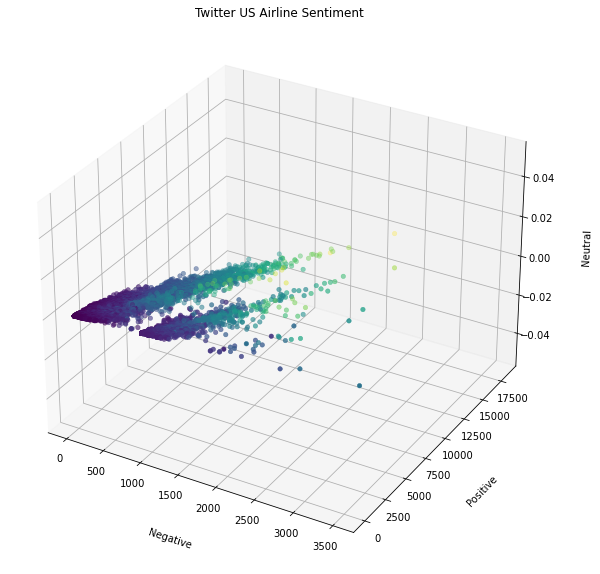

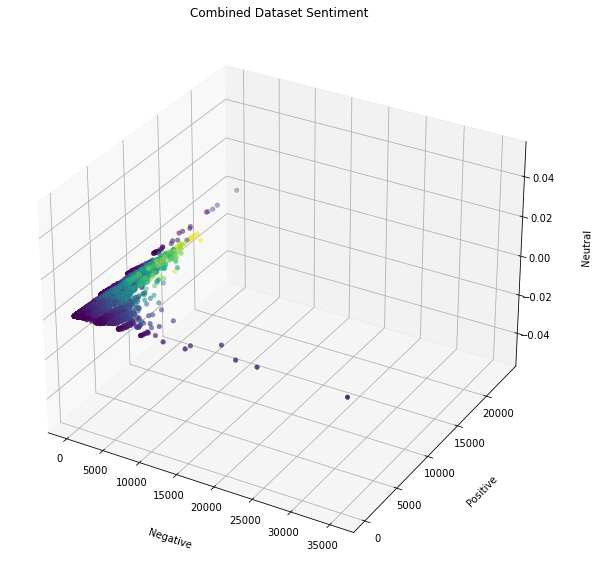

In [49]:

# Plot training data
plot_data(airline_X_gd[:,1:],airline_y_gd_train, 'Twitter US Airline Sentiment')
plot_data(combined_X_gd[:,1:],combined_y_gd_train, 'Combined Dataset Sentiment')


as we see in the plot , our feature space is not linear.

In [29]:
X_train = airline_X_gd[:,1:]
y_train = airline_y_gd_train.argmax(axis=1)

X_test = airline_X_gd_test[:,1:]
y_test = airline_y_gd_test.argmax(axis=1)


In [30]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return ((diagonal_sum / sum_of_all_elements) * 100)


# SVM Multiclass Classification

In [31]:
rbf = SVC(kernel='rbf',gamma= 10, C=10)
rbf.fit(X_train, y_train)
y_pred = rbf.predict(X_train)
cm = confusion_matrix(y_pred, y_train)
print("Accuracy of SVM on training set : ", accuracy(cm),"%")

Accuracy of SVM on training set :  99.38524590163934 %


In [32]:
rbf_pred = rbf.predict(X_test)
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))


Accuracy (RBF Kernel):  65.88
F1 (RBF Kernel):  55.44


# Hyperparameter search

In [33]:
gamma_grid = np.array([1, 10, 100])
c_grid = np.array([1, 10, 100])

training_accuracies = np.zeros((3,3))

#ToDo activate at the end 
test_accuracies = np.zeros((3,3))

g = -1
c = -1

for gamma in gamma_grid:
    g = (g+1)%3
    for c_val in c_grid:
        c = (c+1)%3
        rbf = SVC(kernel='rbf',gamma = gamma, C = c_val)

        # SVM training
        rbf.fit(X_train, y_train)  
        y_pred = rbf.predict(X_train)
        
        # Getting Accuracy
        cm = confusion_matrix(y_pred, y_train)
        training_accuracies[g,c] = accuracy(cm)
        if g==1:
            print("%.1f%% training accuracy for gamma=%.3f c=%i" % (accuracy(cm), gamma, c_val))
        #ToDo activate at the end
        # SVM prediction
        y_pred = rbf.predict(X_test)
        
        # Getting Accuracy
        cm = confusion_matrix(y_pred, y_test)
        test_accuracies[g,c] = accuracy(cm)
        
        if g==1:
            print("%.1f%% test accuracy for gamma=%.3f c=%i" % (accuracy(cm), gamma, c_val))

99.4% training accuracy for gamma=10.000 c=1
65.9% test accuracy for gamma=10.000 c=1
99.4% training accuracy for gamma=10.000 c=10
65.9% test accuracy for gamma=10.000 c=10
99.4% training accuracy for gamma=10.000 c=100
65.9% test accuracy for gamma=10.000 c=100


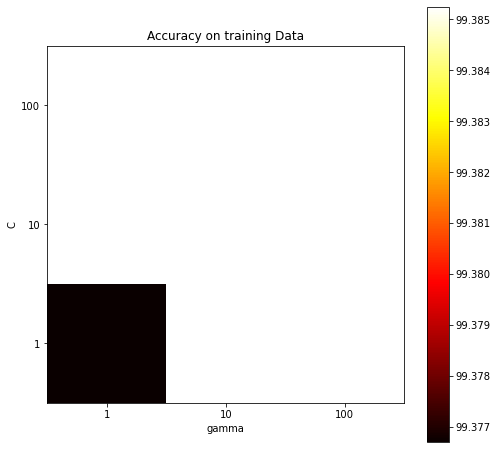

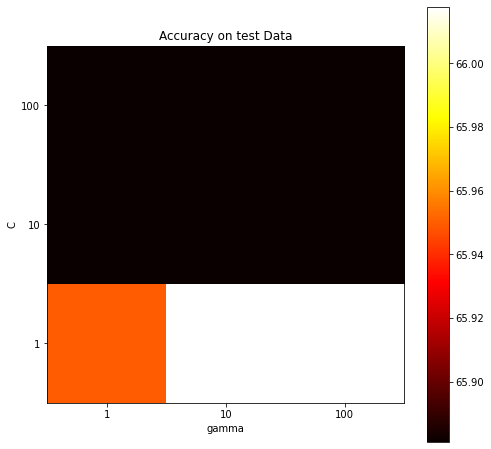

In [34]:
plt.figure(figsize = (8,8))
plt.xticks([0,1,2], gamma_grid)
plt.yticks([0,1,2], c_grid)
plt.imshow(training_accuracies, interpolation='nearest' , origin ='lower', cmap= 'hot')
plt.title('Accuracy on training Data')
plt.colorbar()
plt.xlabel('gamma')
plt.ylabel('C')

#ToDo activate at the end
plt.figure(figsize = (8,8))
plt.xticks([0,1,2], gamma_grid)
plt.yticks([0,1,2], c_grid)
plt.imshow(test_accuracies, interpolation='nearest' , origin ='lower', cmap= 'hot')
plt.colorbar()
plt.title('Accuracy on test Data')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

In [35]:
i,j = np.unravel_index(test_accuracies.argmax(), test_accuracies.shape)
print ("Highest test accuracy= %.1f%% " % (test_accuracies[i,j]))
print ("gamma= %.1f%% ,C= %.1f%% " % (gamma_grid[i],c_grid[j]))

Highest test accuracy= 66.0% 
gamma= 1.0% ,C= 10.0% 


# Multiclass Logistic Regression with scikit learn

In [36]:
model_mlr = LogisticRegression(multi_class='multinomial', solver='sag', random_state=1)
model_mlr.fit(X_train,y_train)

mlr_score = model_mlr.score(X_train,y_train)
print("Accuracy of multinomial logistic regression : ", mlr_score*100,"%")

for k in range(2,10):
    scores = cross_val_score(model_mlr, X_train, y_train, cv=9)
    print("held-out accuracy (%d-fold):   %.1f%%" % (k, scores.mean()*100))

Accuracy of multinomial logistic regression :  73.07035519125684 %
held-out accuracy (2-fold):   73.1%
held-out accuracy (3-fold):   73.1%
held-out accuracy (4-fold):   73.1%
held-out accuracy (5-fold):   73.1%
held-out accuracy (6-fold):   73.1%
held-out accuracy (7-fold):   73.1%
held-out accuracy (8-fold):   73.1%
held-out accuracy (9-fold):   73.1%


In [37]:
mlr_score = model_mlr.score(X_test, y_test)
print("Accuracy of multinomial logistic regression : ", mlr_score*100,"%")

Accuracy of multinomial logistic regression :  72.1311475409836 %


As a final experiment, I would like to repeat the training and testing of our models, but this time with both data sets combined. Let's do a little processing of the data to achieve this objective.

In [38]:
X_train = combined_X_gd[:,1:]
y_train = combined_y_gd_train.argmax(axis=1)

X_test = combined_X_gd_test[:,1:]
y_test = combined_y_gd_test.argmax(axis=1)
print("The data is now ready to go through the training loops and testing outputs.")

The data is now ready to go through the training loops and testing outputs.


## Train SVM on combined dataset:

In [42]:
rbf = SVC(kernel='rbf',gamma= 10, C=10)
rbf.fit(X_train, y_train)
y_pred = rbf.predict(X_train)
cm = confusion_matrix(y_pred, y_train)
print("Accuracy of SVM on training set : ", accuracy(cm),"%")

Accuracy of SVM on training set :  99.52313311688312 %


In [43]:
rbf_pred = rbf.predict(X_test)
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  48.21
F1 (RBF Kernel):  46.64


## Train Multiclass Logistic Regression on combined dataset:

In [46]:
model_mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1)
model_mlr.fit(X_train,y_train)

mlr_score = model_mlr.score(X_train,y_train)
print("Accuracy of multinomial logistic regression : ", mlr_score*100,"%")

for k in range(2,10):
    scores = cross_val_score(model_mlr, X_train, y_train, cv=9)
    print("held-out accuracy (%d-fold):   %.1f%%" % (k, scores.mean()*100))

Accuracy of multinomial logistic regression :  82.83786525974025 %
held-out accuracy (2-fold):   82.8%
held-out accuracy (3-fold):   82.8%
held-out accuracy (4-fold):   82.8%
held-out accuracy (5-fold):   82.8%
held-out accuracy (6-fold):   82.8%
held-out accuracy (7-fold):   82.8%
held-out accuracy (8-fold):   82.8%
held-out accuracy (9-fold):   82.8%


In [50]:
mlr_score = model_mlr.score(X_test, y_test)
print("Accuracy of multinomial logistic regression : ", mlr_score*100,"%")

Accuracy of multinomial logistic regression :  71.65178571428571 %


# 3.0 RNN Model

Run the code cell below to define some useful functions for plotting data and predictions.

In [51]:
def plot_model_evaluation(model):
    fig1 = plt.figure(figsize=(12,5))
    ax1 = fig1.add_subplot(1, 1, 1)
#     s, (at, al) = plt.subplots(2,1)
    ax1.plot(model.history['accuracy'], c= 'b')
    ax1.plot(model.history['val_accuracy'], c='r')
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['LSTM_train', 'LSTM_val'], loc='upper left')
    
    fig2 = plt.figure(figsize=(12,5))
    al = fig2.add_subplot(2, 1, 1)
    al.plot(model.history['loss'], c='m')
    al.plot(model.history['val_loss'], c='c')
    al.set_title('model loss')
    al.set_ylabel('loss')
    al.set_xlabel('epoch')
    al.legend(['train', 'val'], loc = 'upper left')
    
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
warnings.filterwarnings('ignore')

## Dataset Preprocessing

In [52]:
df = pd.read_csv('tweets.csv')
filtered_df = df[['text','airline_sentiment']]
print(filtered_df.shape)
filtered_df.head(5)

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [53]:
filtered_df =  filtered_df[filtered_df.airline_sentiment != "neutral"]
filtered_df = filtered_df.dropna()
print(filtered_df.shape)
filtered_df.head(5)

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

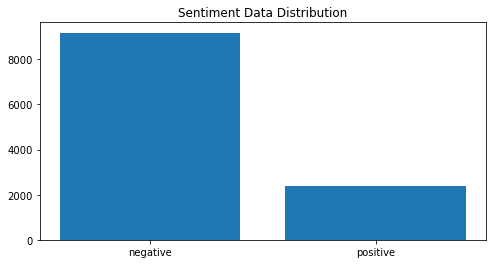

In [54]:
val_count = filtered_df.airline_sentiment.value_counts()
print(val_count)
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [55]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)
df.text = filtered_df.text.apply(lambda x: preprocess(x))


In [56]:
MAX_NB_WORDS = 100
MAX_SEQUENCE_LENGTH = 10
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(filtered_df, test_size=0.2,random_state=7) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 9232
Test Data size 2309


## Tokenization

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 11623
Training X Shape: (9232, 10)
Testing X Shape: (2309, 10)


## Label Encoding

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [58]:
labels = train_data.airline_sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.airline_sentiment.to_list())

y_train = encoder.transform(train_data.airline_sentiment.to_list())
y_test = encoder.transform(test_data.airline_sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (9232, 1)
y_test shape: (2309, 1)


## Build the Text Classifier

In [59]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           371936    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 388,587
Trainable params: 388,587
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
history = model.fit(x_train,y_train,validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
231/231 [==============================] - 7s 17ms/step - loss: 0.4465 - accuracy: 0.8192 - val_loss: 0.3519 - val_accuracy: 0.8495
Epoch 2/5
231/231 [==============================] - 3s 15ms/step - loss: 0.2957 - accuracy: 0.8852 - val_loss: 0.2958 - val_accuracy: 0.8863
Epoch 3/5
231/231 [==============================] - 3s 15ms/step - loss: 0.2116 - accuracy: 0.9197 - val_loss: 0.2928 - val_accuracy: 0.8933
Epoch 4/5
231/231 [==============================] - 3s 15ms/step - loss: 0.1674 - accuracy: 0.9393 - val_loss: 0.3179 - val_accuracy: 0.8890
Epoch 5/5
231/231 [==============================] - 3s 15ms/step - loss: 0.1434 - accuracy: 0.9473 - val_loss: 0.3303 - val_accuracy: 0.8852


## Model Evaluation

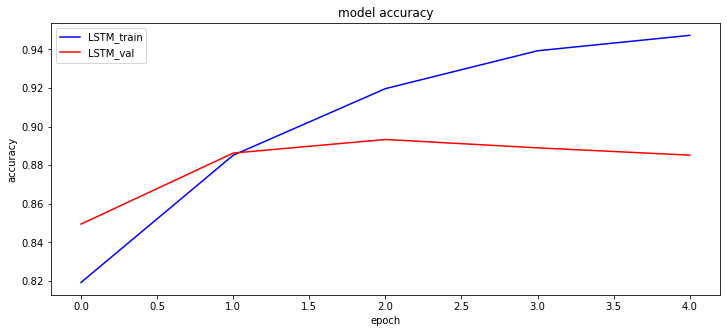

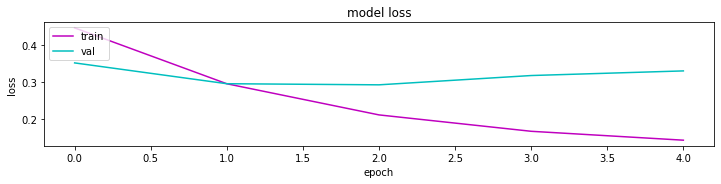

In [61]:
plot_model_evaluation(history)

In [62]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10)
y_pred_1d = [decode_sentiment(score) for score in scores]

231/231 [==============================] - 1s 2ms/step


In [63]:
print(classification_report(list(test_data.airline_sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00       0.0
    negative       0.00      0.00      0.00    1849.0
    positive       0.00      0.00      0.00     460.0

    accuracy                           0.00    2309.0
   macro avg       0.00      0.00      0.00    2309.0
weighted avg       0.00      0.00      0.00    2309.0



# 3.1Train RNN on ntlk dataset which is well balanced:

## Dataset Preprocessing

In [64]:
#import dataset from nltk
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

#create labels
one_array = [1] * len(all_positive_tweets)
zero_array = [0] * len(all_negative_tweets)

all_tweets = all_positive_tweets + all_negative_tweets
all_labels = one_array + zero_array
tweets_and_labels = np.vstack((all_tweets,all_labels)).T

#introduce randomization to the training and test sets
np.random.shuffle(tweets_and_labels)

#extract X (data) and y (labels) columns
nltk_X = tweets_and_labels[:,0].tolist()
nltk_y = tweets_and_labels[:,1].T.astype(int).tolist()

#split the data set into train and test sets with a 80/20 ratio
nltk_X_train, nltk_X_test, nltk_y_train, nltk_y_test = train_test_split(nltk_X, nltk_y, test_size=0.20)
nltk_y_train = np.array([nltk_y_train]).T
nltk_y_test = np.array([nltk_y_test]).T

In [65]:
print(tweets_and_labels[:5,1])
nltk_df = pd.DataFrame(tweets_and_labels)
nltk_df.head()

['1' '1' '1' '1' '0']


,0,1
0,"@BeanssGilly @_kyle__86 thank you, you too! :)",1
1,@Kritters_ whenever we have another movie nigh...,1
2,@UltraVratik @DesaiEshita @jitubhaiyajgd @dine...,1
3,Hi BAM ! @BarsAndMelody \nCan you follow my be...,1
4,The last few episodes were really intense :(((...,0


In [66]:
nltk_df.columns = ['text', 'sentiment']
nltk_df.head()

,text,sentiment
0,"@BeanssGilly @_kyle__86 thank you, you too! :)",1
1,@Kritters_ whenever we have another movie nigh...,1
2,@UltraVratik @DesaiEshita @jitubhaiyajgd @dine...,1
3,Hi BAM ! @BarsAndMelody \nCan you follow my be...,1
4,The last few episodes were really intense :(((...,0


In [67]:
lab_to_sentiment = {0:"Negative", 1:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
nltk_df.sentiment = nltk_df.sentiment.apply(lambda x: label_decoder(int(x)))
nltk_df.head()

,text,sentiment
0,"@BeanssGilly @_kyle__86 thank you, you too! :)",Positive
1,@Kritters_ whenever we have another movie nigh...,Positive
2,@UltraVratik @DesaiEshita @jitubhaiyajgd @dine...,Positive
3,Hi BAM ! @BarsAndMelody \nCan you follow my be...,Positive
4,The last few episodes were really intense :(((...,Negative


Positive    5000
Negative    5000
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Data Distribution')

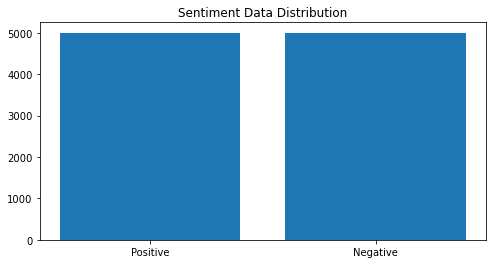

In [68]:
val_count = nltk_df.sentiment.value_counts()
print(val_count)
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [69]:
nltk_df.text = nltk_df.text.apply(lambda x: preprocess(x))

MAX_NB_WORDS = 100
MAX_SEQUENCE_LENGTH = 10
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(nltk_df, test_size=0.2,random_state=7) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 8000
Test Data size 2000


## Tokenization

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 12362
Training X Shape: (8000, 10)
Testing X Shape: (2000, 10)


## Label Encoding

In [71]:
labels = train_data.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8000, 1)
y_test shape: (2000, 1)


## Build the Text Classifier

In [72]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           395584    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 412,235
Trainable params: 412,235
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
history = model.fit(x_train,y_train,validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
200/200 [==============================] - 5s 14ms/step - loss: 0.6592 - accuracy: 0.6048 - val_loss: 0.5720 - val_accuracy: 0.6981
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4810 - accuracy: 0.7708 - val_loss: 0.5043 - val_accuracy: 0.7419
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.3460 - accuracy: 0.8541 - val_loss: 0.5254 - val_accuracy: 0.7456
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2639 - accuracy: 0.8925 - val_loss: 0.5621 - val_accuracy: 0.7538
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2085 - accuracy: 0.9158 - val_loss: 0.6112 - val_accuracy: 0.7475
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1696 - accuracy: 0.9306 - val_loss: 0.6749 - val_accuracy: 0.7331
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1549 - accuracy: 0.9409 - val_loss: 0.7356 - val_accuracy: 0.7400

## Model Evaluation

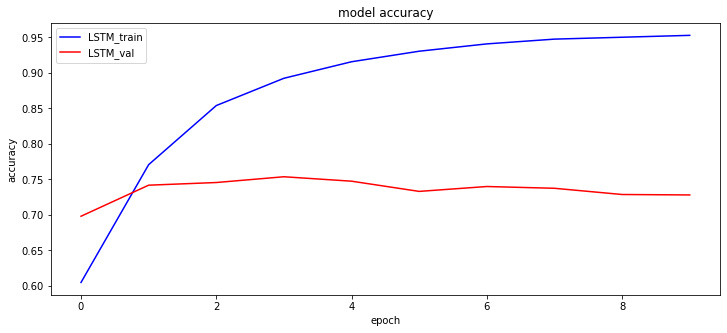

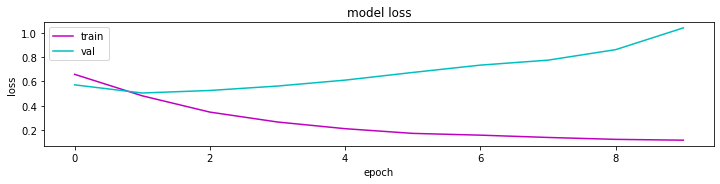

In [74]:
plot_model_evaluation(history)


In [75]:
scores = model.predict(x_test, verbose=1, batch_size=10)
y_pred_1d = [decode_sentiment(score) for score in scores]

200/200 [==============================] - 1s 2ms/step


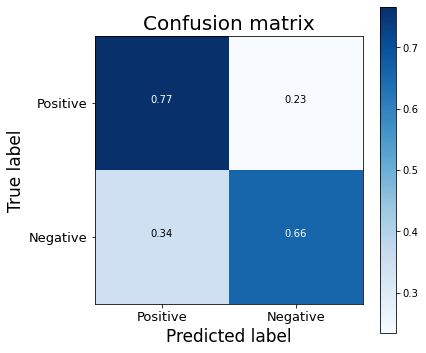

In [76]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes= test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [77]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.69      0.77      0.73       995
    Positive       0.74      0.66      0.70      1005

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000

